### Imports 

In [20]:
import numpy as np
import pandas as pd
import json
#from dscribe.descriptors import CoulombMatrix
from ase import Atoms
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 22}

matplotlib.rc('font', **font)



In [21]:
def pad_with(vector, pad_width, iaxis, kwargs):
     pad_value = kwargs.get('padder', 10)
     vector[:pad_width[0]] = pad_value
     vector[-pad_width[1]:] = pad_value


def coulomb_matrix(atoms, n_atoms_max):
    # Creating a matrix with the product of the atomic numbers such that M_ij = Z[i]*Z[j]
    atomic_numbers = np.outer(atoms.get_atomic_numbers(),atoms.get_atomic_numbers())
    # Getting the distance matrix of the atoms object, such that element D_ij = |r_i - r_j|
    distances = atoms.get_all_distances()
    # Setting the diagonal elements, which are all zero, to 1 to avoid overflow errors
    np.fill_diagonal(distances, 1)
    
    # Creating the Cmat
    cmat = np.multiply(atomic_numbers, 1/distances) # Element wise multiplication
    np.fill_diagonal(cmat, 0.5*np.array(atoms.get_atomic_numbers())**2.4) # Filling the diagonal as described in the slides
    
    # Taking the sorted eigenvalues and padding with zeros such that all of the fingerprints have the same size
    shape = cmat.shape
    cmat,_ = np.linalg.eig(cmat)
    cmat = np.flip(np.sort(cmat))
    holder = np.zeros(n_atoms_max)
    holder[:shape[0]] = cmat
    cmat = holder
    
    return cmat



## Loading data and setting up the data frames

In [22]:
data_dir = "" # Specify your data path (Folder in which the files are placed)

In [23]:
# Loading the data as pandas DataFrame
train = pd.DataFrame(json.load(open(data_dir + "train.json", "rb")))
train = train[train.dynamic_stability_level != 1] # remove unstable
test = pd.DataFrame(json.load(open(data_dir + "test.json", "rb")))
## Transform atoms entry to ASE atoms object
train.atoms = train.atoms.apply(lambda x: Atoms(**x)) # OBS This one is important!
test.atoms = test.atoms.apply(lambda x: Atoms(**x))

In [24]:
print('Train data shape: {}'.format(train.shape))
train.head()

Train data shape: (1559, 5)


,formula,etot,dynamic_stability_level,atoms,Voigt_modulus
1,NiI2,-9.774512,2,"(Atom('Ni', [-7.814021732e-19, -1.673235808e-1...",31.358817
3,Hf4N3O2,-85.216280,3,"(Atom('Hf', [0.0, 1.8605461437, 11.1322923235]...",279.073400
6,Cr2Cl2Se2,-34.354062,3,"(Atom('Cr', [2.5217362911, 5.385447366e-16, 9....",47.686173
8,MoBrI,-13.552381,2,"(Atom('Mo', [1.543915598e-17, -1.192455131e-16...",15.989285
9,Tl2I6,-14.982825,2,"(Atom('Tl', [3.8955234015, 2.2490814845, 9.460...",5.012215


In [25]:
train.atoms[1]

Atoms(symbols='Hf4N3O2', pbc=[True, True, False], cell=[[3.2225604508, -6.60462343e-21, 0.0], [-1.6112802254, 2.7908192156, 0.0], [0.0, 0.0, 24.8736800674]])

In [26]:
print('Test data shape: {}'.format(test.shape))
test.head()

Test data shape: (264, 3)


,formula,etot,atoms
0,Ti2Te2,-21.567884,"(Atom('Te', [0.0001635792, 0.0005756553, 7.369..."
1,Cu2O2,-19.429111,"(Atom('Cu', [-3.606786318e-18, -0.0002926462, ..."
2,Y3C2,-33.214554,"(Atom('Y', [3.531761251e-18, -5.785592543e-18,..."
3,Ti2O4,-51.580206,"(Atom('Ti', [1.135647763e-19, 0.0301387729, 8...."
4,BiMoAs,-19.967820,"(Atom('Mo', [6.983934515e-18, 2.357780987e-16,..."


In [27]:
test.atoms[1]

Atoms(symbols='CuOCuO', pbc=[True, True, False], cell=[[2.8049685284, 1.734570062e-17, 0.0], [-3.746612841e-17, 5.602487274, 0.0], [-7.217855535e-18, 0.0, 16.9711719]])

In [28]:
np.unique(train.dynamic_stability_level,return_counts=True)

(array([2, 3], dtype=int64), array([ 538, 1021], dtype=int64))

## Creating the Coulomb matrix fingerprint
#### First a preprocessing step

In [29]:
species = []
number_of_atoms = []
atomic_numbers = []
for atom in pd.concat([train.atoms,test.atoms]):
    species = list(set(species+atom.get_chemical_symbols()))
    atomic_numbers = list(set(atomic_numbers+list(atom.get_atomic_numbers())))
    number_of_atoms.append(atom.get_number_of_atoms())

max_number_of_atoms = np.max(number_of_atoms)
min_atomic_number = np.min(atomic_numbers)
max_atomic_number = np.max(atomic_numbers)

print(max_number_of_atoms)

12


C:\software\anoconda\lib\site-packages\ase\atoms.py:971: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  warnings.warn('Use get_global_number_of_atoms() instead',


#### Coulomb matrix

In [30]:
cmats = np.zeros((len(train),max_number_of_atoms))
for i,atoms in enumerate(train.atoms):
    if i%1000 == 0:
        print(i)
    cmat = coulomb_matrix(atoms,max_number_of_atoms)
    cmats[i,:] = cmat.flatten()
print(len(cmats))

0
1000
1559


In [31]:
cmat.shape

(12,)

In [32]:
print(len(cmats), cmats.shape)

1559 (1559, 12)


# Setting target and feature vector

In [33]:
X = pd.DataFrame(data = cmats, index=train.index)
y = train['Voigt_modulus']
print('X: {}'.format(X.shape))
print('y: {}'.format(y.shape))

X: (1559, 12)
y: (1559,)


## Splitting into test and train set

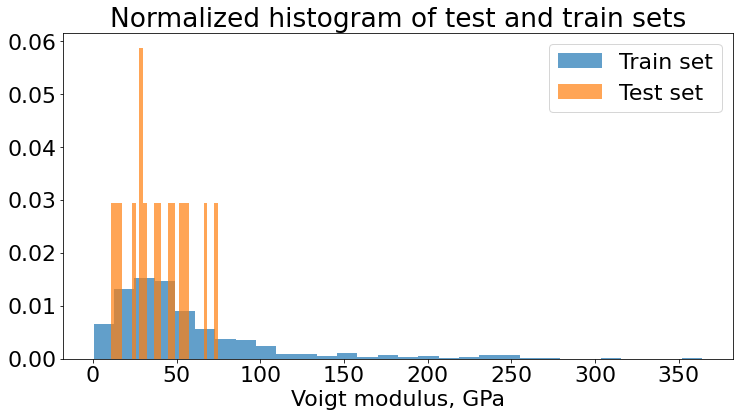

In [34]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.01,random_state=250)
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

plt.figure(figsize = (12, 6))
plt.hist(y_train, bins=30, alpha=0.7, density=True, label='Train set')
plt.hist(y_test, bins=30, alpha=0.7, density=True, label='Test set')

plt.title("Normalized histogram of test and train sets")
plt.xlabel("Voigt modulus, GPa")
plt.legend()
plt.show()


In [35]:
print('X_train: {}'.format(X_train.shape))
print('y_train: {}'.format(y_train.shape))
print('X_test: {}'.format(X_test.shape))
print('y_test: {}'.format(y_test.shape))

X_train: (1543, 12)
y_train: (1543,)
X_test: (16, 12)
y_test: (16,)


In [36]:
X_train[:5]

,0,1,2,3,4,5,6,7,8,9,10,11
93,7985.760045,2732.554525,2206.022711,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1390,3841.894307,2415.091602,2102.436086,1985.188098,1367.067515,1338.763044,0.0,0.0,0.0,0.0,0.0,0.0
1626,16502.619903,12706.579813,6783.714019,6437.045033,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1047,18553.536919,14119.633004,95.970248,81.146593,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
159,3029.232593,2074.539321,1135.207480,987.013323,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


# Sklearn Ridge Regression model

In [37]:
# from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [48]:
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from sklearn.kernel_ridge import KernelRidge
import sklearn.model_selection as ms

model = KernelRidge(kernel='rbf')
param_grid = {'alpha': np.logspace(-5, 5, 20),
              'gamma': np.logspace(-5, 5, 20)}
gp = ms.GridSearchCV(model, param_grid=param_grid, cv=5, n_jobs=4, verbose=1)

# X_train,X_test,y_train,y_test
# Fit to data using Maximum Likelihood Estimation of the parameters

gp.fit(X_train, y_train)

for i in range(10):
    print('loop:', i)
    best_params = gp.best_params_
    print(best_params)
    model.set_params(**best_params)
    print(model)
    gp.fit(X_train, y_train)

train_prediction = gp.predict(X_train)
# train_prediction
test_prediction = gp.predict(X_test)
# test_prediction
print('Train RMSE = {:.2f}'.format(rmse(y_train,train_prediction)))
print('Test RMSE = {:.2f}'.format(rmse(y_test,test_prediction)))

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   22.2s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   55.4s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:  2.3min finished


loop: 0
{'alpha': 0.04832930238571752, 'gamma': 6.1584821106602545}
KernelRidge(alpha=0.04832930238571752, gamma=6.1584821106602545, kernel='rbf')
Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   32.9s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   57.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:  2.4min finished


loop: 1
{'alpha': 0.04832930238571752, 'gamma': 6.1584821106602545}
KernelRidge(alpha=0.04832930238571752, gamma=6.1584821106602545, kernel='rbf')
Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   33.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:  2.4min finished


loop: 2
{'alpha': 0.04832930238571752, 'gamma': 6.1584821106602545}
KernelRidge(alpha=0.04832930238571752, gamma=6.1584821106602545, kernel='rbf')
Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   25.7s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   59.2s
[Parallel(n_jobs=4)]: Done 1440 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 1890 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


loop: 3
{'alpha': 0.04832930238571752, 'gamma': 6.1584821106602545}
KernelRidge(alpha=0.04832930238571752, gamma=6.1584821106602545, kernel='rbf')
Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   23.3s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   54.8s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:  2.1min finished


loop: 4
{'alpha': 0.04832930238571752, 'gamma': 6.1584821106602545}
KernelRidge(alpha=0.04832930238571752, gamma=6.1584821106602545, kernel='rbf')
Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   24.6s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   59.2s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:  2.2min finished


loop: 5
{'alpha': 0.04832930238571752, 'gamma': 6.1584821106602545}
KernelRidge(alpha=0.04832930238571752, gamma=6.1584821106602545, kernel='rbf')
Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   30.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   54.0s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:  2.3min finished


loop: 6
{'alpha': 0.04832930238571752, 'gamma': 6.1584821106602545}
KernelRidge(alpha=0.04832930238571752, gamma=6.1584821106602545, kernel='rbf')
Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.8s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   54.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:  2.3min finished


loop: 7
{'alpha': 0.04832930238571752, 'gamma': 6.1584821106602545}
KernelRidge(alpha=0.04832930238571752, gamma=6.1584821106602545, kernel='rbf')
Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   23.7s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   54.2s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:  2.2min finished


loop: 8
{'alpha': 0.04832930238571752, 'gamma': 6.1584821106602545}
KernelRidge(alpha=0.04832930238571752, gamma=6.1584821106602545, kernel='rbf')
Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   23.1s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   55.3s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:  2.2min finished


loop: 9
{'alpha': 0.04832930238571752, 'gamma': 6.1584821106602545}
KernelRidge(alpha=0.04832930238571752, gamma=6.1584821106602545, kernel='rbf')
Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   24.4s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   57.5s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:  2.2min finished


Train RMSE = 18.11
Test RMSE = 22.82


In [41]:
gp.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__alpha': 0.04832930238571752,
 'estimator__coef0': 1,
 'estimator__degree': 3,
 'estimator__gamma': 6.1584821106602545,
 'estimator__kernel': 'rbf',
 'estimator__kernel_params': None,
 'estimator': KernelRidge(alpha=0.04832930238571752, gamma=6.1584821106602545, kernel='rbf'),
 'iid': 'deprecated',
 'n_jobs': 4,
 'param_grid': {'alpha': array([1.00000000e-05, 3.35981829e-05, 1.12883789e-04, 3.79269019e-04,
         1.27427499e-03, 4.28133240e-03, 1.43844989e-02, 4.83293024e-02,
         1.62377674e-01, 5.45559478e-01, 1.83298071e+00, 6.15848211e+00,
         2.06913808e+01, 6.95192796e+01, 2.33572147e+02, 7.84759970e+02,
         2.63665090e+03, 8.85866790e+03, 2.97635144e+04, 1.00000000e+05]),
  'gamma': array([1.00000000e-05, 3.35981829e-05, 1.12883789e-04, 3.79269019e-04,
         1.27427499e-03, 4.28133240e-03, 1.43844989e-02, 4.83293024e-02,
         1.62377674e-01, 5.45559478e-01, 1.83298071e+00, 6.15848211e+00,
         2.06913808e+01, 

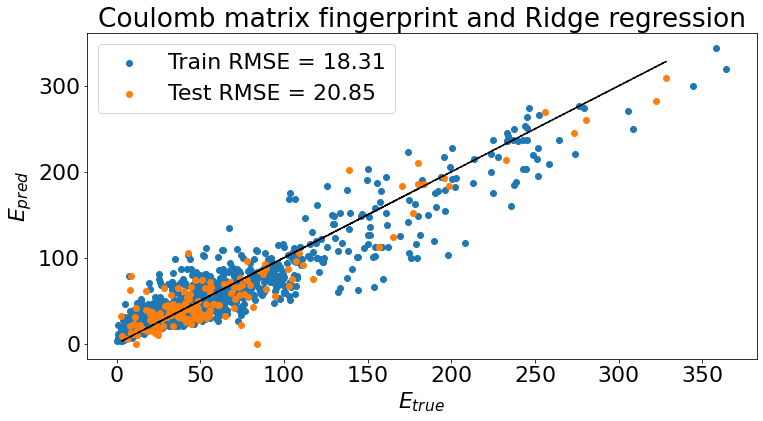

In [54]:
fig = plt.figure(figsize = (12, 6))

plt.title("Coulomb matrix fingerprint and Ridge regression")
plt.scatter(y_train, gp.predict(X_train), label = 'Train RMSE = {:.2f}'.format(rmse(y_train,train_prediction)))
plt.scatter(y_test, gp.predict(X_test), label = 'Test RMSE = {:.2f}'.format(rmse(y_test,test_prediction)))
plt.plot(y_test, y_test, linestyle = "--", color = "k")
plt.xlabel("$E_{true}$")
plt.ylabel("$E_{pred}$")
plt.legend()
plt.show()

# Prepare submission to Kaggle

In [49]:
cmats_test = np.zeros((len(test),max_number_of_atoms))
for i,atoms in enumerate(test.atoms):
    if i%1000 == 0:
        print(i)
    cmat = coulomb_matrix(atoms,max_number_of_atoms)
    cmats_test[i,:] = cmat.flatten()
print(len(cmats))

0
1559


In [50]:
X_test_kaggle = pd.DataFrame(data = cmats_test, index=test.index)
X_test_kaggle.loc[:,:] = scaler.transform(X_test_kaggle)
X_test_kaggle.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.218437,0.083888,-0.452135,-0.270193,-0.347681,-0.340167,-0.222048,-0.219194,-0.129151,-0.115997,-0.075245,-0.072679
1,-0.990869,-0.786313,-0.767274,-0.562259,-0.347681,-0.340167,-0.222048,-0.219194,-0.129151,-0.115997,-0.075245,-0.072679
2,-0.676532,-0.474723,0.277707,-0.565685,-0.327235,-0.340167,-0.222048,-0.219194,-0.129151,-0.115997,-0.075245,-0.072679
3,-1.116016,-0.912795,-0.762890,-0.557731,-0.303456,-0.303240,-0.222048,-0.219194,-0.129151,-0.115997,-0.075245,-0.072679
4,1.672852,-0.293881,-0.009796,-0.583863,-0.347681,-0.340167,-0.222048,-0.219194,-0.129151,-0.115997,-0.075245,-0.072679


In [51]:
print(len(X_test_kaggle))

264


In [54]:
test_prediction_dataframe = pd.DataFrame(data = {'ID':test.index,
                                                 'Voigt_modulus':gp.predict(X_test_kaggle)})
test_prediction_dataframe.head()

,ID,Voigt_modulus
0,0,28.076112
1,1,65.482095
2,2,104.471052
3,3,102.895579
4,4,40.871913


In [47]:
test_prediction_dataframe.to_csv(data_dir+'submission_test.csv',index=False)